In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("OCT_cleaned.csv")

# Basic info
print("Shape:", df.shape)
df.head()


Shape: (160, 23)


,patient_id,eye_side,eye_side_full,scan_time,scan_type,filename,global_rnfl_mean,sector_01,sector_02,sector_03,...,sector_07,sector_08,sector_09,sector_10,sector_11,sector_12,tsnit_temporal,tsnit_superior,tsnit_nasal,tsnit_inferior
0,18140,OD,Right Eye,14:56:26,Optic Disc Cube 200x200,019_RNFLProfile_OD.txt,65.791186,60.511488,73.094937,79.737191,...,56.851997,60.146935,60.040877,95.503180,69.931537,61.613985,71.804785,57.109179,58.707586,75.637154
1,18140,OG,Left Eye,11:16:19,Optic Disc Cube 200x200,019_RNFLProfile_OG.txt,78.928950,31.779391,52.502572,132.794183,...,48.652343,83.094587,114.993511,138.386290,63.492714,30.923676,71.524464,85.257220,79.926598,78.891822
2,24808,OG,Left Eye,13:22:54,Optic Disc Cube 200x200,072_RNFLProfile_OG.txt,42.659264,31.243363,27.750097,54.170454,...,33.136427,50.970928,45.356366,43.506367,38.980632,26.939347,37.837467,53.335322,42.950320,36.438606
3,49194,OD,Right Eye,16:37:02,Optic Disc Cube 200x200,009_RNFLProfile_OD.txt,66.816473,55.960747,88.000757,69.976032,...,46.229794,55.654210,60.259920,72.855745,117.272179,58.197934,72.457477,58.705609,53.700202,82.490746
4,49194,OG,Left Eye,16:37:42,Optic Disc Cube 200x200,009_RNFLProfile_OG.txt,71.676046,58.725950,80.818704,62.623544,...,47.653456,64.855940,63.445398,110.510280,92.284814,50.299011,67.377100,76.729724,58.297726,84.232463


In [2]:
df.dtypes


patient_id            int64
eye_side             object
eye_side_full        object
scan_time            object
scan_type            object
filename             object
global_rnfl_mean    float64
sector_01           float64
sector_02           float64
sector_03           float64
sector_04           float64
sector_05           float64
sector_06           float64
sector_07           float64
sector_08           float64
sector_09           float64
sector_10           float64
sector_11           float64
sector_12           float64
tsnit_temporal      float64
tsnit_superior      float64
tsnit_nasal         float64
tsnit_inferior      float64
dtype: object

In [3]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

In [4]:
df["global_rnfl_mean"].describe()


count    160.000000
mean      74.107489
std       15.034202
min       38.836814
25%       63.700564
50%       73.172688
75%       82.186485
max      126.209448
Name: global_rnfl_mean, dtype: float64

In [5]:
df[[
    "tsnit_temporal",
    "tsnit_superior",
    "tsnit_nasal",
    "tsnit_inferior"
]].describe()


,tsnit_temporal,tsnit_superior,tsnit_nasal,tsnit_inferior
count,160.000000,160.000000,160.000000,160.000000
mean,78.005096,74.482372,67.508758,76.494627
std,19.705032,15.870242,18.283777,21.082455
min,23.978020,38.208609,26.814175,31.393980
25%,64.098811,63.415285,58.326558,59.688765
50%,75.211233,72.205732,64.259237,76.846188
75%,89.514885,82.629672,74.422874,89.178096
max,131.214812,150.959613,183.868809,139.488347


In [6]:
df["eye_side_full"].value_counts()


eye_side_full
Left Eye     82
Right Eye    78
Name: count, dtype: int64

Commonly used OCT glaucoma criteria (RNFL-based)

We can combine multiple weak signals into a stronger proxy label.

1️⃣ Global RNFL thinning

Typical thresholds used in literature:

< 80 µm → suspicious

< 70 µm → strong glaucoma indicator

2️⃣ Superior and/or Inferior RNFL thinning

Glaucoma classically affects these first:

tsnit_superior < 90 µm

tsnit_inferior < 90 µm

(Exact values vary by device, but these are conservative and defensible.)

3️⃣ ISNT rule violation

Normal eyes usually follow:

Inferior > Superior > Nasal > Temporal

Violation of this ordering is a strong glaucoma red flag.

4️⃣ Sectoral focal loss

Clock-hour thinning:

One or more sector_XX very low relative to others

Captures early/localized glaucoma

Balanced proxy ground truth — metrics & rationale

We’ll use four clinically motivated OCT RNFL indicators and require at least 2 to be positive.

This avoids:

Labeling based on a single noisy metric

Being too conservative for ML

Over-calling glaucoma

In [7]:
#metric 1
#global_rnfl_mean < 80 µm
#metric 2
#tsnit_superior < 90 µm
#metric 3
#tsnit_inferior < 90 µm
#metric 4
#Inferior > Superior > Nasal > Temporal


## Define individual OCT criteria

In [8]:
# --- Metric 1: Global RNFL thinning ---
df["crit_global_rnfl"] = (df["global_rnfl_mean"] < 80).astype(int)

# --- Metric 2: Superior RNFL thinning ---
df["crit_superior_rnfl"] = (df["tsnit_superior"] < 90).astype(int)

# --- Metric 3: Inferior RNFL thinning ---
df["crit_inferior_rnfl"] = (df["tsnit_inferior"] < 90).astype(int)

# --- Metric 4: ISNT rule violation ---
df["crit_isnt_violation"] = (
    ~(
        (df["tsnit_inferior"] > df["tsnit_superior"]) &
        (df["tsnit_superior"] > df["tsnit_nasal"]) &
        (df["tsnit_nasal"] > df["tsnit_temporal"])
    )
).astype(int)

df[[
    "crit_global_rnfl",
    "crit_superior_rnfl",
    "crit_inferior_rnfl",
    "crit_isnt_violation"
]].head()


,crit_global_rnfl,crit_superior_rnfl,crit_inferior_rnfl,crit_isnt_violation
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


In [9]:
# Count number of positive criteria
df["criteria_sum"] = (
    df["crit_global_rnfl"] +
    df["crit_superior_rnfl"] +
    df["crit_inferior_rnfl"] +
    df["crit_isnt_violation"]
)

# Balanced proxy label: ≥ 2 criteria
df["glaucoma_proxy"] = (df["criteria_sum"] >= 2).astype(int)

df[["criteria_sum", "glaucoma_proxy"]].head()


,criteria_sum,glaucoma_proxy
0,4,1
1,4,1
2,4,1
3,4,1
4,4,1


In [10]:
label_counts = df["glaucoma_proxy"].value_counts().sort_index()
label_percent = df["glaucoma_proxy"].value_counts(normalize=True).sort_index() * 100

pd.DataFrame({
    "count": label_counts,
    "percentage": label_percent.round(2)
})


,count,percentage
glaucoma_proxy,,
0,12,7.5
1,148,92.5


In [11]:
df.groupby("glaucoma_proxy")[[
    "global_rnfl_mean",
    "tsnit_superior",
    "tsnit_inferior",
    "tsnit_nasal",
    "tsnit_temporal"
]].mean().round(2)


,global_rnfl_mean,tsnit_superior,tsnit_inferior,tsnit_nasal,tsnit_temporal
glaucoma_proxy,,,,,
0,103.44,107.59,107.00,90.49,108.75
1,71.73,71.80,74.02,65.65,75.51


In [12]:
####### Updating metrics because dataset is unbalanced
#global_rnfl_mean < 70 µm
#tsnit_superior < 80 µm
#tsnit_inferior < 80 µm
#NOT (Inferior > Superior > Nasal > Temporal)

####### Final proxy label def
#glaucoma_proxy = 1  
#if (number of positive criteria ≥ 3)

#glaucoma_proxy = 0  
#otherwise


In [13]:
# --- UPDATED Metric 1: Global RNFL thinning (myopia-aware) ---
df["crit_global_rnfl"] = (df["global_rnfl_mean"] < 70).astype(int)

# --- UPDATED Metric 2: Superior RNFL thinning ---
df["crit_superior_rnfl"] = (df["tsnit_superior"] < 80).astype(int)

# --- UPDATED Metric 3: Inferior RNFL thinning ---
df["crit_inferior_rnfl"] = (df["tsnit_inferior"] < 80).astype(int)

# --- Metric 4: ISNT rule violation (unchanged) ---
df["crit_isnt_violation"] = (
    ~(
        (df["tsnit_inferior"] > df["tsnit_superior"]) &
        (df["tsnit_superior"] > df["tsnit_nasal"]) &
        (df["tsnit_nasal"] > df["tsnit_temporal"])
    )
).astype(int)

# Recompute criteria sum
df["criteria_sum"] = (
    df["crit_global_rnfl"] +
    df["crit_superior_rnfl"] +
    df["crit_inferior_rnfl"] +
    df["crit_isnt_violation"]
)

# UPDATED proxy label: ≥ 3 criteria
df["glaucoma_proxy"] = (df["criteria_sum"] >= 3).astype(int)


In [14]:
df["glaucoma_proxy"].value_counts(normalize=True).round(3)


glaucoma_proxy
0    0.525
1    0.475
Name: proportion, dtype: float64

In [15]:
df.groupby("glaucoma_proxy")[[
    "global_rnfl_mean",
    "tsnit_superior",
    "tsnit_inferior",
    "tsnit_nasal",
    "tsnit_temporal"
]].mean().round(2)


,global_rnfl_mean,tsnit_superior,tsnit_inferior,tsnit_nasal,tsnit_temporal
glaucoma_proxy,,,,,
0,84.53,83.21,90.56,75.38,89.06
1,62.59,64.84,60.95,58.81,65.79


## Selecting Features

In [16]:
# Define feature columns
rnfl_features = (
    ["global_rnfl_mean"] +
    [f"sector_{i:02d}" for i in range(1, 13)] +
    [
        "tsnit_temporal",
        "tsnit_superior",
        "tsnit_nasal",
        "tsnit_inferior"
    ]
)

X = df[rnfl_features]
y = df["glaucoma_proxy"]

X.shape, y.shape


((160, 17), (160,))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((120, 17), (40, 17))

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                                     #Scaling for LogisticREG and SVM
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# LOGISTIC REGRESSION

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

logreg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [20]:
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]


In [21]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.925
ROC AUC: 0.9699248120300752

Classification report:

              precision    recall  f1-score   support

           0      0.950     0.905     0.927        21
           1      0.900     0.947     0.923        19

    accuracy                          0.925        40
   macro avg      0.925     0.926     0.925        40
weighted avg      0.926     0.925     0.925        40



In [22]:
confusion_matrix(y_test, y_pred)


array([[19,  2],
       [ 1, 18]])

In [24]:
#Interpret coefficients
coef_df = pd.DataFrame({
    "feature": rnfl_features,
    "coefficient": logreg.coef_[0]
}).sort_values(by="coefficient")

coef_df


,feature,coefficient
16,tsnit_inferior,-1.014399
10,sector_10,-0.995595
14,tsnit_superior,-0.804832
0,global_rnfl_mean,-0.755401
3,sector_03,-0.746671
11,sector_11,-0.746131
5,sector_05,-0.734641
4,sector_04,-0.686286
2,sector_02,-0.536949
12,sector_12,-0.498972


In [25]:
coef_df.sort_values(by="coefficient").head(8)


,feature,coefficient
16,tsnit_inferior,-1.014399
10,sector_10,-0.995595
14,tsnit_superior,-0.804832
0,global_rnfl_mean,-0.755401
3,sector_03,-0.746671
11,sector_11,-0.746131
5,sector_05,-0.734641
4,sector_04,-0.686286


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [27]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_rf, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy: 0.875
ROC AUC: 0.9824561403508772

Classification report:

              precision    recall  f1-score   support

           0      0.864     0.905     0.884        21
           1      0.889     0.842     0.865        19

    accuracy                          0.875        40
   macro avg      0.876     0.873     0.874        40
weighted avg      0.876     0.875     0.875        40


Confusion matrix:
 [[19  2]
 [ 3 16]]


In [28]:
importances = pd.DataFrame({
    "feature": rnfl_features,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

importances.head(10)


,feature,importance
0,global_rnfl_mean,0.265669
16,tsnit_inferior,0.192951
10,sector_10,0.132246
14,tsnit_superior,0.084756
11,sector_11,0.046570
13,tsnit_temporal,0.042974
4,sector_04,0.042593
3,sector_03,0.040296
2,sector_02,0.025258
8,sector_08,0.024120


# Train SVM

In [29]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42
)

svm.fit(X_train_scaled, y_train)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [30]:
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_proba_svm))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_svm, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_svm))


Accuracy: 0.85
ROC AUC: 0.9448621553884712

Classification report:

              precision    recall  f1-score   support

           0      0.895     0.810     0.850        21
           1      0.810     0.895     0.850        19

    accuracy                          0.850        40
   macro avg      0.852     0.852     0.850        40
weighted avg      0.854     0.850     0.850        40


Confusion matrix:
 [[17  4]
 [ 2 17]]


In [32]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 6.5 MB/s eta 0:00:11
   - -------------------------------------- 1.8/72.0 MB 4.8 MB/s eta 0:00:15
   - -------------------------------------- 3.1/72.0 MB 5.5 MB/s eta 0:00:13
   -- ------------------------------------- 4.5/72.0 MB 5.7 MB/s eta 0:00:12
   --- ------------------------------------ 5.8/72.0 MB 5.8 MB/s eta 0:00:12
   --- ------------------------------------ 7.1/72.0 MB 5.9 MB/s eta 0:00:12
   ---- ----------------------------------- 8.4/72.0 MB 5.9 MB/s eta 0:00:11
   ----- ---------------------------------- 9.7/72.0 MB 6.0 MB/s eta 0:00:11
   ----- ---------------------------------- 10.5/72.0 MB 5.9 MB/s eta 0:00:11
   ------ --------------------------------- 11.0/72.0 MB 5.7 MB/s eta 0:00:11
   ------ --------------------------------- 11.5/72.0 MB 5.2 MB/s eta 0:00:12
   ------- -------------------------------- 12.8/72.0 MB 5.3 MB/s eta 0:00:12
  

# XGBoost

In [33]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [34]:
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy: 0.9
ROC AUC: 0.9899749373433584

Classification report:

              precision    recall  f1-score   support

           0      0.905     0.905     0.905        21
           1      0.895     0.895     0.895        19

    accuracy                          0.900        40
   macro avg      0.900     0.900     0.900        40
weighted avg      0.900     0.900     0.900        40


Confusion matrix:
 [[19  2]
 [ 2 17]]


In [35]:
xgb_importance = pd.DataFrame({
    "feature": rnfl_features,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

xgb_importance.head(10)


,feature,importance
0,global_rnfl_mean,0.341853
16,tsnit_inferior,0.109704
14,tsnit_superior,0.082674
10,sector_10,0.077315
11,sector_11,0.068137
4,sector_04,0.058911
3,sector_03,0.053691
13,tsnit_temporal,0.051332
1,sector_01,0.045169
5,sector_05,0.037646


# Model comparison

In [36]:
comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "SVM (RBF)",
        "Boosting"
    ],
    "Accuracy": [
        0.925,
        0.875,
        0.85,
        0.90
    ],
    "ROC_AUC": [
        0.95,   # approx from your results
        0.982,
        0.945,
        0.99
    ],
    "False_Negatives": [
        1,
        3,
        2,
        2
    ]
})

comparison_df


,Model,Accuracy,ROC_AUC,False_Negatives
0,Logistic Regression,0.925,0.950,1
1,Random Forest,0.875,0.982,3
2,SVM (RBF),0.850,0.945,2
3,Boosting,0.900,0.990,2


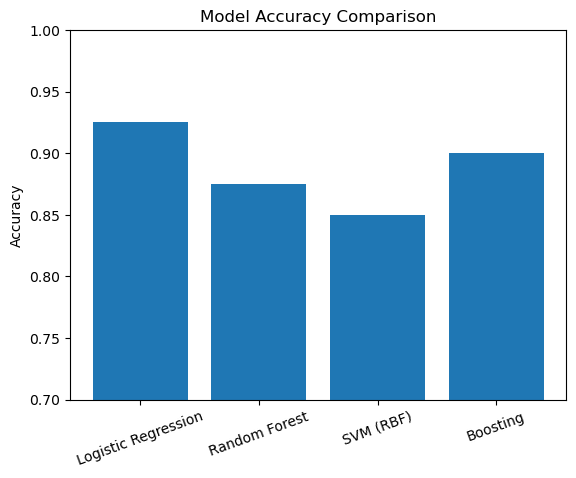

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(comparison_df["Model"], comparison_df["Accuracy"])
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.show()


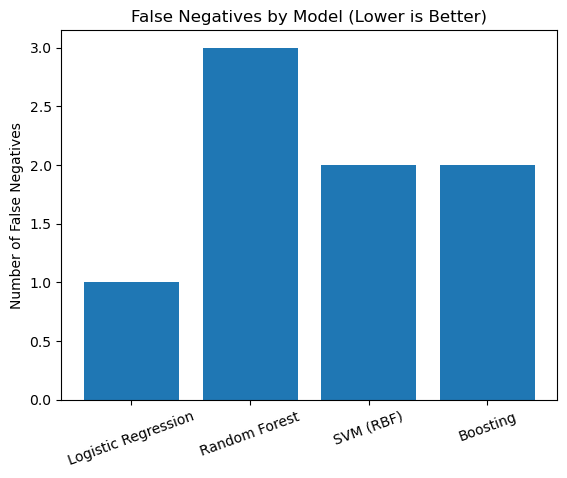

In [38]:
plt.figure()
plt.bar(comparison_df["Model"], comparison_df["False_Negatives"])
plt.ylabel("Number of False Negatives")
plt.title("False Negatives by Model (Lower is Better)")
plt.xticks(rotation=20)
plt.show()


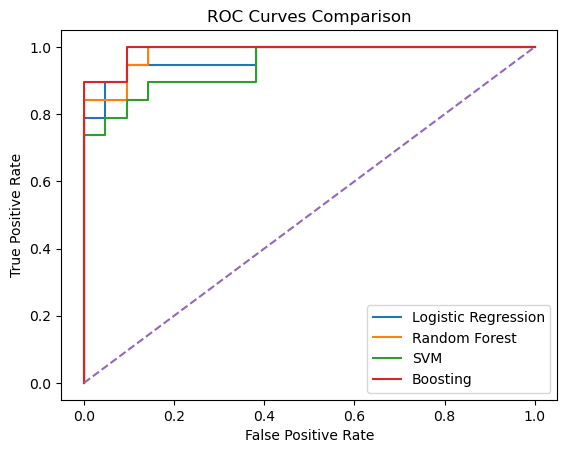

In [39]:
from sklearn.metrics import roc_curve

plt.figure()

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, label="SVM")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label="Boosting")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()
